<a href="https://colab.research.google.com/github/NicoCasPer/T_Aprendizaje_Maquina/blob/main/TallerTAM/6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


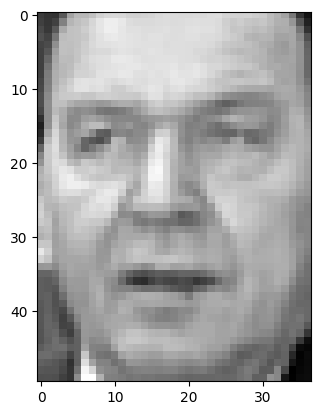

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [4]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [5]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.43286065070595453)

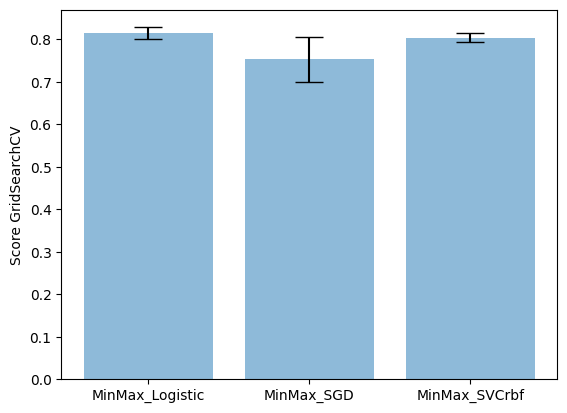

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.753 0.804]
 [0.014 0.053 0.011]]


In [6]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


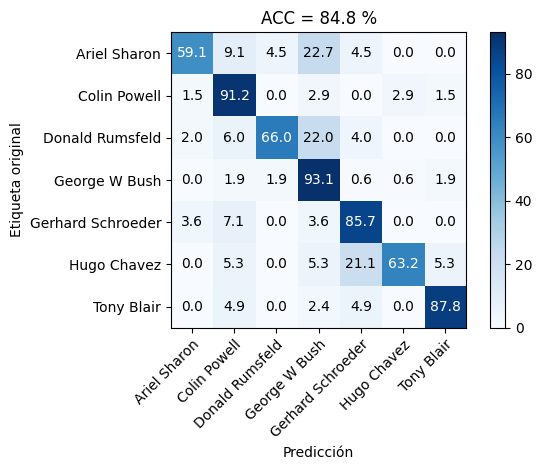

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


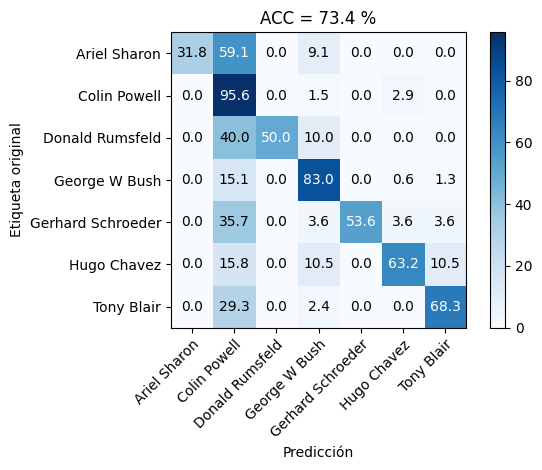

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.32      0.48        22
     Colin Powell       0.44      0.96      0.60        68
  Donald Rumsfeld       1.00      0.50      0.67        50
    George W Bush       0.92      0.83      0.87       159
Gerhard Schroeder       1.00      0.54      0.70        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.85      0.68      0.76        41

         accuracy                           0.73       387
        macro avg       0.85      0.64      0.68       387
     weighted avg       0.84      0.73      0.74       387

Evaluando modelo MinMax_SVCrbf (3/3)


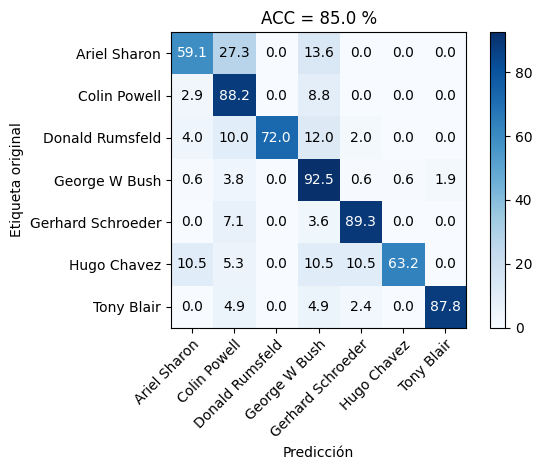

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [7]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


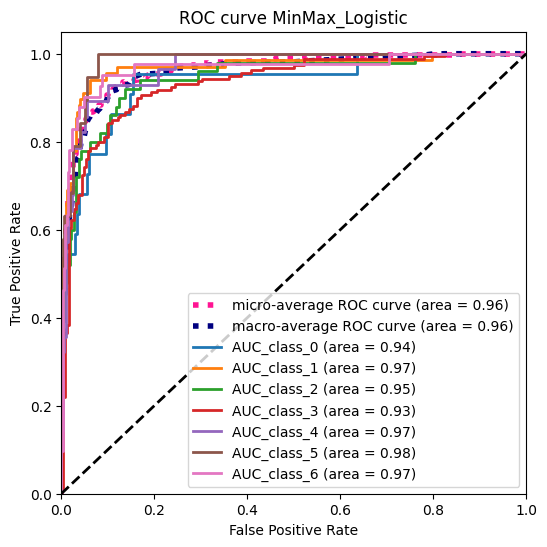

Evaluando modelo MinMax_SGD (2/3)


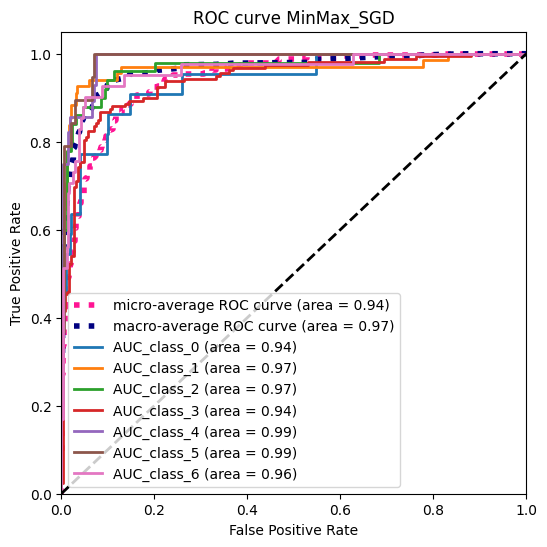

Evaluando modelo MinMax_SVCrbf (3/3)


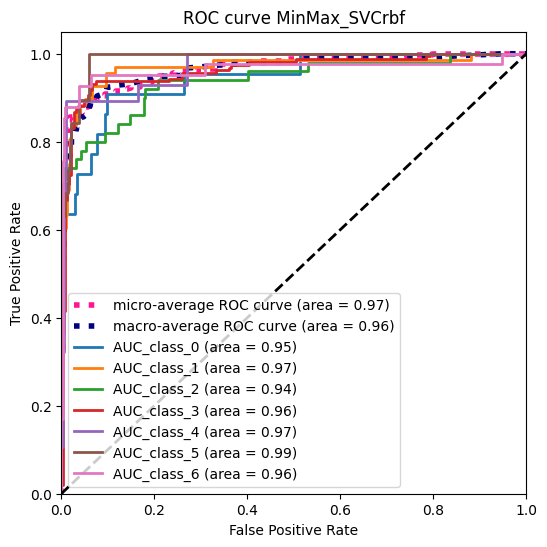

In [8]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


In [9]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00


In [10]:
import joblib
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# Definir la lista de clasificadores
classifiers = [
    ('GaussianNB', GaussianNB()),
    ('SGDClassifier', SGDClassifier()),
    ('LogisticRegression', LogisticRegression()),
    ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('LinearSVC', LinearSVC()),
    ('SVC', SVC()),
    ('RandomForestClassifier', RandomForestClassifier())
]

# Definir los espacios de búsqueda para cada clasificador
search_spaces = {
    'GaussianNB': {'cla__var_smoothing': Real(1e-10, 1e-1, prior='log-uniform')},
    'SGDClassifier': {
        'cla__alpha': Real(1e-5, 1e-1, prior='log-uniform'),
        'cla__loss': Categorical(['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']),
        'cla__penalty': Categorical(['l2', 'l1', 'elasticnet', None]),
        'cla__learning_rate': Categorical(['constant', 'optimal', 'invscaling', 'adaptive']),
        'cla__eta0': Real(1e-4, 1e-1, prior='log-uniform')
    },
    'LogisticRegression': [ # Use a list of dictionaries for different valid combinations
        { # Solver: liblinear (supports l1 and l2)
            'cla__C': Real(1e-4, 1e4, prior='log-uniform'),
            'cla__penalty': Categorical(['l1', 'l2']),
            'cla__solver': Categorical(['liblinear'])
        },
        { # Solvers: lbfgs, sag (supports l2 and None)
            'cla__C': Real(1e-4, 1e4, prior='log-uniform'),
            'cla__penalty': Categorical(['l2', None]),
            'cla__solver': Categorical(['lbfgs', 'sag'])
        },
        { # Solver: saga (supports l1, l2, elasticnet, None)
            'cla__C': Real(1e-4, 1e4, prior='log-uniform'),
            'cla__penalty': Categorical(['l1', 'l2', 'elasticnet']),
            'cla__solver': Categorical(['saga']),
            'cla__l1_ratio': Real(0, 1, transform='identity') # l1_ratio is only for elasticnet with saga
        },
         { # Solver: saga (supports None penalty)
            'cla__C': Real(1e-4, 1e4, prior='log-uniform'),
            'cla__penalty': Categorical([None]),
            'cla__solver': Categorical(['saga']),
        }
    ],
    'LinearDiscriminantAnalysis':[
        # Prioritize the 'svd' solver which is robust to singularity
        {
            'cla__solver': Categorical(['svd']),
            'cla__shrinkage': Categorical([None]), # SVD does not support shrinkage
        },
        # Include 'lsqr' with and without shrinkage as it can also handle some cases
        {
            'cla__solver': Categorical(['lsqr']),
            'cla__shrinkage': Categorical([None, 'auto']),
        },
        {
             'cla__solver': Categorical(['lsqr']),
             'cla__shrinkage': Real(0, 1),
        }
    ],
    'KNeighborsClassifier': {
        'cla__n_neighbors': Integer(1, 30),
        'cla__weights': Categorical(['uniform', 'distance']),
        'cla__metric': Categorical(['minkowski', 'euclidean', 'manhattan']),
        'cla__p': Integer(1, 2)
    },
    'LinearSVC': {
        'cla__C': Real(1e-4, 1e4, prior='log-uniform'),
        'cla__loss': Categorical(['hinge', 'squared_hinge']),
        # LinearSVC with l1 penalty requires dual=False, which can be slower
        'cla__penalty': Categorical(['l2']),
        'cla__dual': Categorical([True]) # dual=True is default and preferred for n_samples > n_features
    },
    'SVC': {
        'cla__C': Real(1e-4, 1e4, prior='log-uniform'),
        'cla__kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
        'cla__degree': Integer(2, 5), # Degree is only for 'poly' kernel
        'cla__gamma': Real(1e-3, 1e1, prior='log-uniform'),
        'cla__coef0': Real(-1, 1) # coef0 is for 'poly' and 'sigmoid' kernels
    },
    'RandomForestClassifier': {
        'cla__n_estimators': Integer(50, 500),
        'cla__max_depth': Integer(3, 30),
        'cla__min_samples_split': Integer(2, 10),
        'cla__min_samples_leaf': Integer(1, 5),
        'cla__max_features': Categorical(['sqrt', 'log2', None])
    }
}

# Realizar optimización bayesiana para cada modelo
models = []
filename = 'results/lfw_models_bayes'

for name, cla in classifiers:
    print(f'Model: {name}')
    pipeline = Pipeline([
        ('nor', MinMaxScaler()),
        ('cla', cla)
    ])

    # Obtener el espacio de búsqueda para el clasificador actual
    search_space = search_spaces[name]

    # Set error_score to 'raise' for the problematic LDA model to debug further if needed,
    # or keep 0 for other models to continue the search if a specific configuration fails.
    # For now, we'll keep error_score=0 to see if the updated search space resolves the issue.
    bayes_search = BayesSearchCV(
        pipeline,
        search_space,
        n_iter=10, # Increased iterations for potentially better results
        cv=5,
        n_jobs=-1,
        scoring='accuracy',
        refit=True,
        verbose=10,
        error_score='raise' # Set error_score to 'raise' to identify problematic configurations
    )

    # For LinearSVC with l1 penalty, set dual=False explicitly in the pipeline
    if name == 'LinearSVC':
        # The search space for LinearSVC now only includes l2 penalty with dual=True by default
        # If you still need to explore l1, you would need a separate search space entry with dual=False
        pass # No change needed here as the search space is updated

    try:
        bayes_search.fit(Xtrain, ytrain)
        models.append(bayes_search)
    except Exception as e:
        print(f"Fitting failed for model {name} with error: {e}")
        print("Skipping this model.")
        # You might want to log the failed model or handle it differently

# Guardar todos los models (only the ones that successfully fit)
joblib.dump(models, filename + ".pkl")

Model: GaussianNB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Model: SGDClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds f

['results/lfw_models_bayes.pkl']

Evaluando modelo MinMax_GNB (1/8)


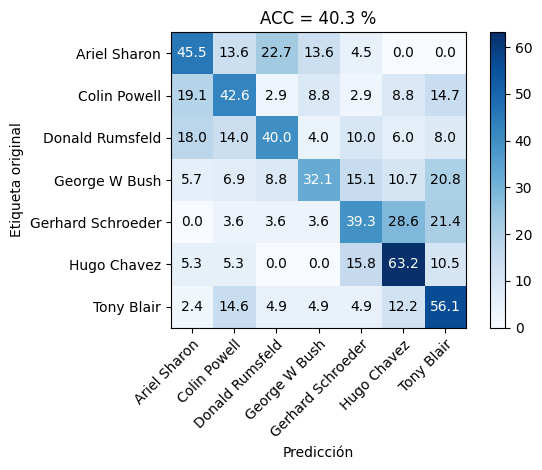

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387

Evaluando modelo MinMax_SGD (2/8)


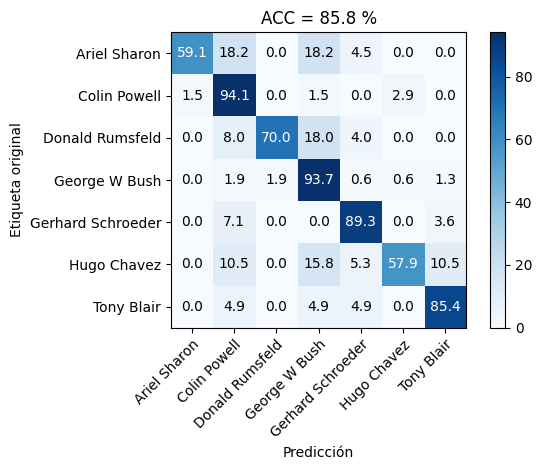

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.59      0.72        22
     Colin Powell       0.79      0.94      0.86        68
  Donald Rumsfeld       0.92      0.70      0.80        50
    George W Bush       0.89      0.94      0.91       159
Gerhard Schroeder       0.78      0.89      0.83        28
      Hugo Chavez       0.79      0.58      0.67        19
       Tony Blair       0.88      0.85      0.86        41

         accuracy                           0.86       387
        macro avg       0.85      0.78      0.81       387
     weighted avg       0.86      0.86      0.85       387

Evaluando modelo MinMax_LR (3/8)


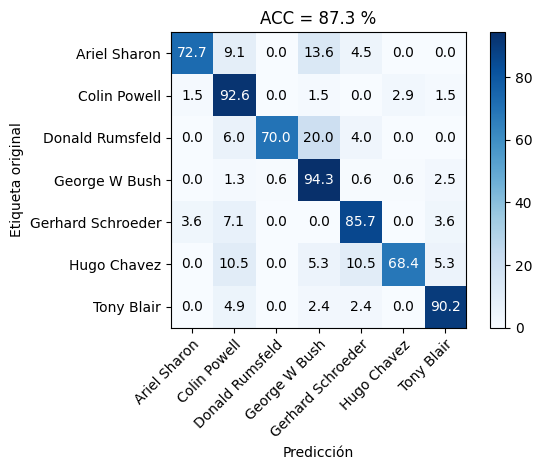

                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.73      0.80        22
     Colin Powell       0.83      0.93      0.88        68
  Donald Rumsfeld       0.97      0.70      0.81        50
    George W Bush       0.90      0.94      0.92       159
Gerhard Schroeder       0.77      0.86      0.81        28
      Hugo Chavez       0.81      0.68      0.74        19
       Tony Blair       0.84      0.90      0.87        41

         accuracy                           0.87       387
        macro avg       0.86      0.82      0.83       387
     weighted avg       0.88      0.87      0.87       387

Evaluando modelo MinMax_LDA (4/8)


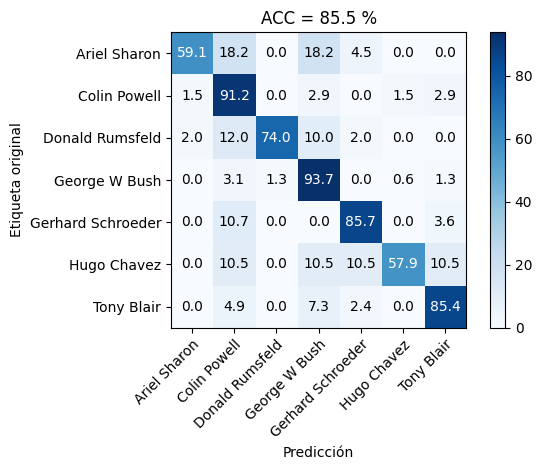

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.59      0.70        22
     Colin Powell       0.74      0.91      0.82        68
  Donald Rumsfeld       0.95      0.74      0.83        50
    George W Bush       0.90      0.94      0.92       159
Gerhard Schroeder       0.83      0.86      0.84        28
      Hugo Chavez       0.85      0.58      0.69        19
       Tony Blair       0.83      0.85      0.84        41

         accuracy                           0.86       387
        macro avg       0.85      0.78      0.81       387
     weighted avg       0.86      0.86      0.85       387

Evaluando modelo MinMax_KNN (5/8)


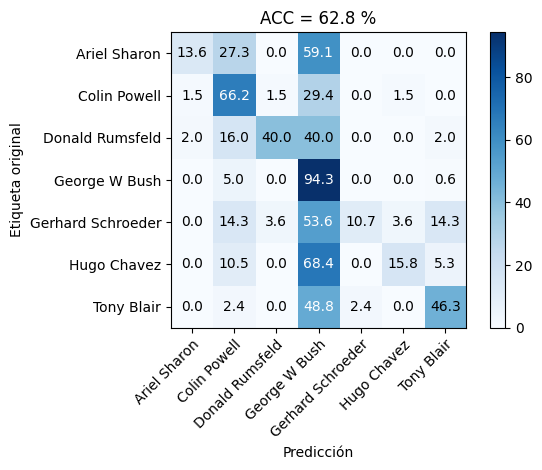

                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.14      0.22        22
     Colin Powell       0.61      0.66      0.63        68
  Donald Rumsfeld       0.91      0.40      0.56        50
    George W Bush       0.60      0.94      0.73       159
Gerhard Schroeder       0.75      0.11      0.19        28
      Hugo Chavez       0.60      0.16      0.25        19
       Tony Blair       0.73      0.46      0.57        41

         accuracy                           0.63       387
        macro avg       0.69      0.41      0.45       387
     weighted avg       0.67      0.63      0.58       387

Evaluando modelo MinMax_LinearSVC (6/8)


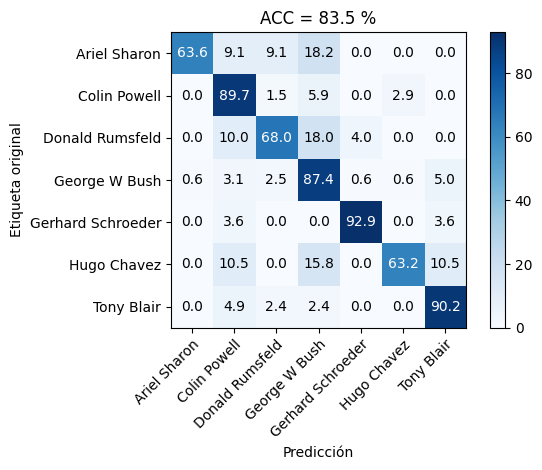

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.64      0.76        22
     Colin Powell       0.78      0.90      0.84        68
  Donald Rumsfeld       0.81      0.68      0.74        50
    George W Bush       0.87      0.87      0.87       159
Gerhard Schroeder       0.90      0.93      0.91        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.77      0.90      0.83        41

         accuracy                           0.83       387
        macro avg       0.84      0.79      0.81       387
     weighted avg       0.84      0.83      0.83       387

Evaluando modelo MinMax_SVC (7/8)


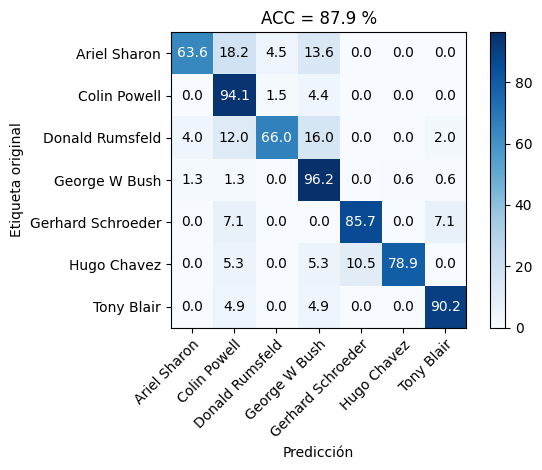

                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.64      0.70        22
     Colin Powell       0.79      0.94      0.86        68
  Donald Rumsfeld       0.94      0.66      0.78        50
    George W Bush       0.90      0.96      0.93       159
Gerhard Schroeder       0.92      0.86      0.89        28
      Hugo Chavez       0.94      0.79      0.86        19
       Tony Blair       0.90      0.90      0.90        41

         accuracy                           0.88       387
        macro avg       0.88      0.82      0.84       387
     weighted avg       0.88      0.88      0.88       387

Evaluando modelo MinMax_RF (8/8)


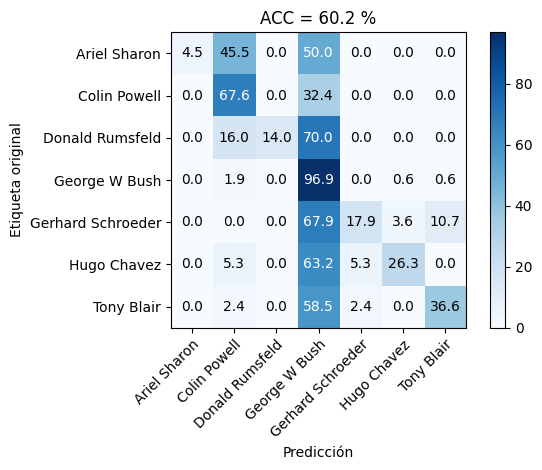

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.05      0.09        22
     Colin Powell       0.67      0.68      0.67        68
  Donald Rumsfeld       1.00      0.14      0.25        50
    George W Bush       0.56      0.97      0.71       159
Gerhard Schroeder       0.71      0.18      0.29        28
      Hugo Chavez       0.71      0.26      0.38        19
       Tony Blair       0.79      0.37      0.50        41

         accuracy                           0.60       387
        macro avg       0.78      0.38      0.41       387
     weighted avg       0.70      0.60      0.54       387

Evaluando modelo MinMax_GNB (1/8)
Using predict_proba
Could not generate ROC curve for MinMax_GNB due to error: 'micro'
Skipping ROC plot for this model.
Evaluando modelo MinMax_SGD (2/8)
Using decision_function
Could not generate ROC curve for MinMax_SGD due to error: 'micro'
Skipping ROC plot for this model.
Evaluando modelo MinMax_LR (3/8)
Usi

In [11]:
import joblib
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np # Import numpy for checking the shape of scores
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import seaborn as sns # Assuming sns is used for colors in roc_auc_mc

def get_scores(model, X):
    if hasattr(model, 'decision_function'):
        print("Using decision_function") # Add print statements for debugging
        return model.decision_function(X)
    elif hasattr(model, 'predict_proba'):
        print("Using predict_proba") # Add print statements for debugging
        return model.predict_proba(X)
    else:
        raise AttributeError("Model does not have decision_function or predict_proba")

def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Ensure yscore has the same number of columns as ytrue
    if ytrue.shape[1] != yscore.shape[1]:
         raise ValueError(f"Number of classes in ytrue ({ytrue.shape[1]}) does not match number of score columns in yscore ({yscore.shape[1]})")

    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], roc_auc["micro"]) # Fix: should be auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


# Cargar los modelos entrenados con optimización bayesiana
my_model_loaded = joblib.load('results/lfw_models_bayes.pkl')

# Definir los nombres de los modelos según los entrenados
# Ensure this list matches the order of classifiers in the training loop
label_models = ['MinMax_GNB', 'MinMax_SGD', 'MinMax_LR', 'MinMax_LDA', 'MinMax_KNN', 'MinMax_LinearSVC', 'MinMax_SVC', 'MinMax_RF']


# Binarizar las etiquetas de ytest para la curva ROC
ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


# Primer bloque de evaluación: precisión, matriz de confusión y reporte de clasificación
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i], i+1, len(my_model_loaded)))
    # Ensure we are getting the best estimator from the BayesSearchCV result
    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest, ytest_e)

    # Plotear la matriz de confusión
    plot_confusion_matrix(ytest, ytest_e, classes=lfw_people.target_names, title='ACC = %.1f %%' % (100*acc))
    plt.autoscale()
    plt.show()

    # Imprimir el reporte de clasificación
    cr = classification_report(ytest, ytest_e, labels=range(lfw_people.target_names.shape[0]), target_names=lfw_people.target_names)
    print(cr)

# Segundo bloque de evaluación: curva ROC
# Path for saving figures (if needed, currently commented out in plot_confusion_matrix and roc_auc_mc)
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i], i+1, len(my_model_loaded)))
    # Obtener las puntuaciones para la curva ROC (decision_function or predict_proba)
    # Use the get_scores function to handle different model types
    try:
        ytest_score = get_scores(my_model_loaded[i].best_estimator_, Xtest)
        if ytest_score.ndim == 1:
            if len(lfw_people.target_names) == 2: # Check if it's actually a binary classification problem
                 ytest_score = np.vstack([-ytest_score, ytest_score]).T
            else:
                 if ytest_b.shape[1] > 2:
                      raise ValueError(f"Model {label_models[i]} returned 1D scores for a multiclass problem.")
        roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b, ytest_score)
        roc_auc_mc(roc_auc, fpr, tpr, n_classes, 'ROC curve ' + label_models[i], path_img)

    except Exception as e:
        print(f"Could not generate ROC curve for {label_models[i]} due to error: {e}")
        print("Skipping ROC plot for this model.")
        # You might want to investigate the specific model and its scoring methods if this occurs.